# Context Extractor AI
This notebook contains AI model that is able to classify images into their roles (informative, decorative, functional, text, or complex). The model takes image and several text attributes as input and outputs a role.

## Load Data

In [1]:
# Install dependencies
%pip install pandas ftfy

Note: you may need to restart the kernel to use updated packages.


In [63]:
import json
import re
json_path = "../scraper/output-aut-en/output-en.json"
image_dir = "../scraper/output-aut-en/images/"

try:
    # Read the JSON file
    with open(json_path, "r") as file:
        dirty_data = file.read()
        dirty_data = re.sub(r"\](\[\])*\[", ",", dirty_data)
        data = json.loads(dirty_data)

    # Print the first entry in the JSON data
    print(data[0])

    # Print the number of entries in the JSON data
    print(len(data))
    
except Exception as e:
    print(str(e))

{'src': 'https://s.w.org/images/core/emoji/15.0.3/svg/1f606.svg', 'file_name': 'ludacreative.com.au-image_4.jpg', 'doc_title': 'Website Design & Development Sunshine Coast | Luda Creative', 'doc_description': 'Blending innovative web design solutions and custom strategies elevated by a personable touch, making your brand the go-to in your industry.', 'alt': '😆', 'attrs': {'draggable': 'false', 'role': 'img', 'class': ['emoji'], 'alt': '😆', 'src': 'https://s.w.org/images/core/emoji/15.0.3/svg/1f606.svg'}, 'a_button_parent': 'None', 'previous_texts': ["h3: Don't just take our word for it.", 'p: A big ‘hell yes’ to me.', 'p: What’s that sound like?', 'p: Supported by a team of developers, website and graphic designers, SEO strategists and a valuable array of IT support, copywriters, photographers and videographers, you are in the best possible position to grow. your. business.', 'p: Offering direct access to creative director and CEO Kali Lovell at all times, Luda Creative is your go-to s

In [9]:
# installing some dependencies, CLIP was released in PyTorch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

# Updated to use a more recent version of PyTorch that supports newer CUDA versions
if CUDA_version in ["10.0", "10.1"]:
    torch_version_suffix = f"+cu{CUDA_version.replace('.', '')}"
elif CUDA_version == "10.2":
    torch_version_suffix = "+cu102"
elif CUDA_version in ["11.0", "11.1", "11.2", "11.3"]:
    torch_version_suffix = "+cu113"  # Assuming cu113 is compatible with CUDA 11.x versions
else:
    torch_version_suffix = "+cu116"  # Defaulting to a newer CUDA version if none of the above match

# Updated PyTorch version to a more recent one that is likely to have the desired CUDA version available
pytorch_version = "1.13.0"  # Example of a more recent version, adjust as needed

torch_version_suffix = "+cu116"  # Your CUDA version suffix

# Choose a compatible torchvision version
torchvision_version = "0.14.0"  # Example compatible version, adjust based on compatibility

%pip install torch=={pytorch_version}{torch_version_suffix} torchvision=={torchvision_version}{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

CUDA version: 11.5
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu116/torch-1.13.0%2Bcu116-cp311-cp311-linux_x86_64.whl (1983.3 MB)
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.14.0+cu116 (from versions: 0.1.6, 0.2.0, 0.15.0+cpu, 0.15.0+cu117, 0.15.0+cu118, 0.15.1, 0.15.1+cpu, 0.15.1+cu117, 0.15.1+cu118, 0.15.2, 0.15.2+cpu, 0.15.2+cu117, 0.15.2+cu118, 0.15.2+rocm5.3, 0.15.2+rocm5.4.2, 0.16.0, 0.16.0+cpu, 0.16.0+cu118, 0.16.0+cu121, 0.16.0+rocm5.5, 0.16.0+rocm5.6, 0.16.1, 0.16.1+cpu, 0.16.1+cu118, 0.16.1+cu121, 0.16.1+rocm5.5, 0.16.1+rocm5.6, 0.16.2, 0.16.2+cpu, 0.16.2+cu118, 0.16.2+cu121, 0.16.2+rocm5.5, 0.16.2+rocm5.6, 0.17.0, 0.17.0+cpu, 0.17.0+cu118, 0.17.0+cu121, 0.17.0+rocm5.6, 0.17.0+rocm5.7, 0.17.1, 0.17.1+cpu, 0.17.1+cu118, 0.17.1+cu121, 0.17.1+rocm

In [1]:
# clone the CLIP repository
!git clone https://github.com/openai/CLIP.git

import sys
from pathlib import Path

try:
    clip_dir = Path(".").absolute() / "CLIP"
    sys.path.append(str(clip_dir))
    print(f"CLIP dir is: {clip_dir}")
except Exception as e:
    print(e)

import clip

fatal: destination path 'CLIP' already exists and is not an empty directory.
CLIP dir is: /home/felinejtd/projects/itb/ta/image-alt-text-ai/role_classifier/CLIP


In [71]:
import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
import tqdm
import os
from packaging import version
import torchvision
import sklearn.preprocessing
import warnings

In [64]:
# Load pre-trained model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)
model = model.eval()
print(f"Model dir: {os.path.expanduser('~/.cache/clip')}")

Model dir: /home/felinejtd/.cache/clip


In [66]:
class CLIPCapDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        c_data = self.data[idx]
        c_data = clip.tokenize(f"On a website, this text: {c_data} is related to the image", truncate=True).squeeze()
        return {'caption': c_data}

    def __len__(self):
        return len(self.data)

In [67]:
def extract_all_captions(captions, model, device, batch_size=256, num_workers=8):
    data = torch.utils.data.DataLoader(
        CLIPCapDataset(captions),
        batch_size=batch_size, num_workers=num_workers, shuffle=False)
    all_text_features = []
    with torch.no_grad():
        for b in tqdm.tqdm(data):
            b = b['caption'].to(device)
            all_text_features.append(model.encode_text(b).cpu().numpy())
    all_text_features = np.vstack(all_text_features)
    return all_text_features

In [69]:
class CLIPImageDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        # only 224x224 ViT-B/32 supported for now
        self.preprocess = self._transform_test(224)

    def _transform_test(self, n_px):
        return Compose([
            Resize(n_px, interpolation=Image.BICUBIC),
            CenterCrop(n_px),
            lambda image: image.convert("RGB"),
            ToTensor(),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        ])

    def __getitem__(self, idx):
        c_data = self.data[idx]
        image = Image.open(c_data)
        image = self.preprocess(image)
        return {'image':image}

    def __len__(self):
        return len(self.data)

In [70]:
def extract_all_images(images, model, device, batch_size=64, num_workers=8):
    data = torch.utils.data.DataLoader(
        CLIPImageDataset(images),
        batch_size=batch_size, num_workers=num_workers, shuffle=False)
    all_image_features = []
    with torch.no_grad():
        for b in tqdm.tqdm(data):
            b = b['image'].to(device)
            if device == 'cuda':
                b = b.to(torch.float16)
            all_image_features.append(model.encode_image(b).cpu().numpy())
    all_image_features = np.vstack(all_image_features)
    return all_image_features

In [31]:
def get_clip_score(model, images, candidates, device, w=2.5):
    '''
    get standard image-text clipscore.
    images can either be:
    - a list of strings specifying filepaths for images
    - a precomputed, ordered matrix of image features
    '''
    if isinstance(images, list):
        # need to extract image features
        images = extract_all_images(images, model, device)

    candidates = extract_all_captions(candidates, model, device)

    #as of numpy 1.21, normalize doesn't work properly for float16
    if version.parse(np.__version__) < version.parse('1.21'):
        images = sklearn.preprocessing.normalize(images, axis=1)
        candidates = sklearn.preprocessing.normalize(candidates, axis=1)
    else:
        warnings.warn(
            'due to a numerical instability, new numpy normalization is slightly different than paper results. '
            'to exactly replicate paper results, please use numpy version less than 1.21, e.g., 1.20.3.')
        images = images / np.sqrt(np.sum(images**2, axis=1, keepdims=True))
        candidates = candidates / np.sqrt(np.sum(candidates**2, axis=1, keepdims=True))

    per = w*np.clip(np.sum(images * candidates, axis=1), 0, None)
    return np.mean(per), per, candidates

In [43]:
# Test
images=["./test_image/cat.jpg"]
candidates = ["cat", "dog", "bird", "computer", "website", "evil", "cute cat", "orange cat"]
model = model.eval()
score, per, candidates = get_clip_score(model, images, candidates, device)
print(f"Score: {score}")
print(f"Per: {per}")
print(f"Candidates: {candidates}")

100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

Score: 0.61767578125
Per: [0.7056 0.559  0.557  0.5493 0.572  0.5073 0.696  0.794 ]
Candidates: [[ 0.005287   0.00583   -0.01573   ... -0.0305    -0.0448     0.00497  ]
 [-0.00285    0.0235    -0.03009   ... -0.03546   -0.02142    0.0114   ]
 [ 0.01488    0.03375    0.004974  ... -0.0326    -0.00668   -0.02882  ]
 ...
 [-0.0219     0.0248    -0.002857  ... -0.04352    0.01775    0.01703  ]
 [ 0.0009255  0.003786  -0.03134   ... -0.006783  -0.04074   -0.00999  ]
 [ 0.00601    0.03983    0.011734  ...  0.007313  -0.04428   -0.03674  ]]



/tmp/ipykernel_252503/4027130149.py:19: UserWarning: due to a numerical instability, new numpy normalization is slightly different than paper results. to exactly replicate paper results, please use numpy version less than 1.21, e.g., 1.20.3.
  warnings.warn(


# Prep Data

In [72]:
# Shuffle the data
import random
random.shuffle(data)

# Begin Eval

In [73]:
# CLIPScore evaluation
from IPython.display import clear_output

number_of_images = 1000
threshold = 0.65

init = {"is_relevant": 0, "num_data": 0}

max_similarity = 0
min_similarity = 1
prev_text_evals = [init.copy() for _ in range(5)]
next_text_evals = [init.copy() for _ in range(5)]
all_similarities = []

for image in data[0:number_of_images]:
    try:
        # Clear the output
        clear_output()

        image_path = [f"{image_dir}{image['file_name']}"]
        class_captions = image["previous_texts"] + image["next_texts"]
        
        score, per, candidates = get_clip_score(model, image_path, class_captions, device)

        # Save the results
        for i, class_caption in enumerate(class_captions):
            if per[i] > max_similarity:
                max_similarity = per[i]
            if per[i] < min_similarity:
                min_similarity = per[i]
            if per[i] > threshold:
                if i < 5:
                    prev_text_evals[i]["is_relevant"] += 1
                else:
                    next_text_evals[i - 5]["is_relevant"] += 1
            all_similarities.append(per[i])
            if i < 5:
                prev_text_evals[i]["num_data"] += 1
            else:
                next_text_evals[i - 5]["num_data"] += 1

    except Exception as e:
        print(str(e))

# Calculate the percentage
for i in range(5):
    prev_text_evals[i]["is_relevant"] = (prev_text_evals[i]["is_relevant"] / prev_text_evals[i]["num_data"]) * 100
    next_text_evals[i]["is_relevant"] = (next_text_evals[i]["is_relevant"] / next_text_evals[i]["num_data"]) * 100

print("Previous text evaluations:")
print(prev_text_evals)
print("Next text evaluations:")
print(next_text_evals)

  0%|          | 0/1 [00:00<?, ?it/s]Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/felinejtd/anaconda3/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/felinejtd/anaconda3/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/felinejtd/anaconda3/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/felinejtd/anaconda3/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/felinejtd/anaconda3/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/felinejtd/anaconda3/lib/python3.11/multiprocessing/connection.py", line 178, in 

: 

In [17]:
from PIL import Image


number_of_images = 10
threshold = 25

init = {"is_relevant": 0, "num_data": 0}

max_similarity = 0
min_similarity = 100
prev_text_evals = [init.copy() for _ in range(5)]
next_text_evals = [init.copy() for _ in range(5)]
all_similarities = []
 

for image in data[0:number_of_images]:
    try:
        class_captions = image["previous_texts"]
        # Cut all the captions to the same length
        class_captions = [f"On a website, this text: {caption} is related to the image" for caption in class_captions]
        text_input = clip.tokenize(class_captions).to(device)

        with torch.no_grad():
            text_features = model.encode_text(text_input).float()
            text_features /= text_features.norm(dim=-1, keepdim=True)
        
        image_path = image["file_name"]
        # Load the image
        image_input = transform(Image.open(image_dir + image_path)).unsqueeze(0).to(device)
        # Encode the image
        with torch.no_grad():
            image_features = model.encode_image(image_input).float()
            image_features /= image_features.norm(dim=-1, keepdim=True)

        # Display the results
        text_probs = (100.0 * image_features @ text_features.T)
        text_probs = text_probs.cpu()
        print("Prev: ", text_probs)

        # Save the results
        for i, class_caption in enumerate(class_captions):
            if text_probs[0][i].item() > max_similarity:
                max_similarity = text_probs[0][i].item()
            if text_probs[0][i].item() < min_similarity:
                min_similarity = text_probs[0][i].item()
            if text_probs[0][i].item() > threshold:
                prev_text_evals[i]["is_relevant"] += 1
            all_similarities.append(text_probs[0][i].item())
            prev_text_evals[i]["num_data"] += 1

        # Next text
        class_captions = image["next_texts"]
        # Cut all the captions to the same length
        class_captions = [f"On a website, this text: {caption} is related to the image" for caption in class_captions]
        text_input = clip.tokenize(class_captions).to(device)

        with torch.no_grad():
            text_features = model.encode_text(text_input).float()
            text_features /= text_features.norm(dim=-1, keepdim=True)

        # Display the results
        text_probs = (100.0 * image_features @ text_features.T)
        text_probs = text_probs.cpu()
        print("Next: ", text_probs)

        # Save the results
        for i, class_caption in enumerate(class_captions):
            if text_probs[0][i].item() > max_similarity:
                max_similarity = text_probs[0][i].item()
            if text_probs[0][i].item() < min_similarity:
                min_similarity = text_probs[0][i].item()
            if text_probs[0][i].item() > threshold:
                next_text_evals[i]["is_relevant"] += 1
            all_similarities.append(text_probs[0][i].item())
            next_text_evals[i]["num_data"] += 1

    except Exception as e:
        print(str(e))

# Calculate the percentage
for i in range(5):
    prev_text_evals[i]["is_relevant"] = (prev_text_evals[i]["is_relevant"] / prev_text_evals[i]["num_data"]) * 100
    next_text_evals[i]["is_relevant"] = (next_text_evals[i]["is_relevant"] / next_text_evals[i]["num_data"]) * 100

print("Previous text evaluations:")
print(prev_text_evals)
print("Next text evaluations:")
print(next_text_evals)

/home/felinejtd/anaconda3/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Prev:  tensor([[20.8588, 22.3433, 21.4239, 22.2851, 20.6156]])
Next:  tensor([[20.2953, 21.9474, 19.1802, 21.1484, 19.9586]])
Prev:  tensor([], size=(1, 0))
Next:  tensor([[22.6514, 23.3032, 23.5850, 24.5370, 24.7190]])
Prev:  tensor([[22.2969, 21.8405, 23.2572]])
Next:  tensor([[23.3477, 24.8583]])
Prev:  tensor([], size=(1, 0))
Next:  tensor([[23.8488, 24.9880, 24.8607, 25.3858, 26.0285]])
Prev:  tensor([[22.3813, 22.3813, 17.9139, 20.6354, 21.6803]])
Next:  tensor([[30.4990, 30.4990, 26.2010, 26.2010, 19.4660]])
Prev:  tensor([[27.9400, 27.9309, 20.0454, 21.8948, 26.9445]])
Next:  tensor([[30.8561, 24.0930, 24.3390, 18.2692, 23.4173]])
Prev:  tensor([], size=(1, 0))
Input On a website, this text: p: PREDICT-Meso is funded for £5million across 6 years by the Accelerator Awards. The Accelerator Awards are funded through a partnership between Cancer Research UK (CRUK), Fondazione AIRC (AIRC) and Fundación Científica de la Asociacion Española Contra el Cáncer (FC AECC) and seeks to maxi

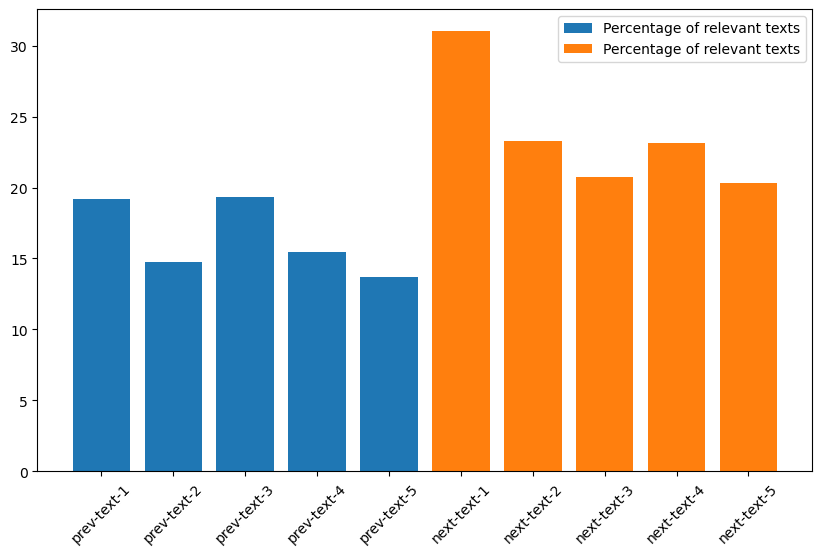

In [17]:
# Plot the results
import matplotlib.pyplot as plt

prev_text_evals = [{'is_relevant': 160, 'num_data': 832}, {'is_relevant': 123, 'num_data': 832}, {'is_relevant': 156, 'num_data': 806}, {'is_relevant': 124, 'num_data': 803}, {'is_relevant': 110, 'num_data': 803}]
next_text_evals = [{'is_relevant': 186, 'num_data': 599}, {'is_relevant': 136, 'num_data': 584}, {'is_relevant': 117, 'num_data': 564}, {'is_relevant': 126, 'num_data': 544}, {'is_relevant': 102, 'num_data': 502}]


for i in range(5):
    prev_text_evals[i]["is_relevant"] = (prev_text_evals[i]["is_relevant"] / prev_text_evals[i]["num_data"]) * 100
    next_text_evals[i]["is_relevant"] = (next_text_evals[i]["is_relevant"] / next_text_evals[i]["num_data"]) * 100

prev_text_evals_to_plot = [x["is_relevant"] for x in prev_text_evals]
next_text_evals_to_plot = [x["is_relevant"] for x in next_text_evals]

plt.figure(figsize=(10, 6))
plt.bar([f"prev-text-{i+1}" for i in range(5)], prev_text_evals_to_plot, label="Percentage of relevant texts")
plt.bar([f"next-text-{i+1}" for i in range(5)], next_text_evals_to_plot, label="Percentage of relevant texts")
plt.legend(loc="upper right")

# Tilt the x-axis labels
plt.xticks(rotation=45)

plt.show()


In [59]:
print(max_similarity)
print(min_similarity)

0.943
0.3555


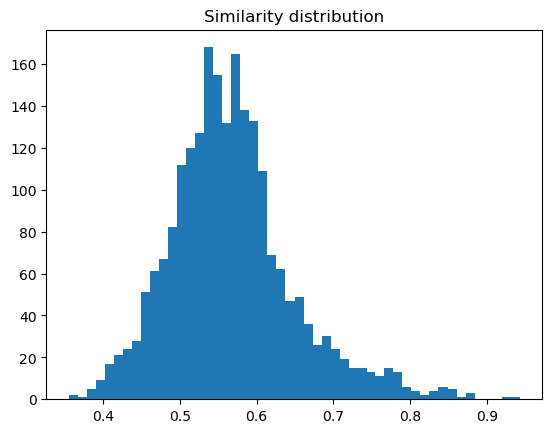

In [60]:
# Plot all_similarities
import matplotlib.pyplot as plt

plt.hist(all_similarities, bins=50)
plt.title("Similarity distribution")
plt.show()
